### Introduction
### Build a machine model to predict whether the freshwater is safe to drink or not.Based on the measures like pH, TDS, etc

### Import necessary packages and libraries

In [ ]:

!pip install -U modin[all] -q --progress-bar off

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearnex import patch_sklearn
patch_sklearn()

from timeit import default_timer as timer

import wandb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split,StratifiedKFold
import optuna
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from optuna.integration.wandb import WeightsAndBiasesCallback
from optuna.samplers import RandomSampler,TPESampler,MOTPESampler,CmaEsSampler
from sklearn.metrics import f1_score,classification_report,confusion_matrix,log_loss,ConfusionMatrixDisplay,roc_curve,precision_recall_curve
from xgboost import XGBClassifier,plot_tree
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback
import math
import daal4py as d4p

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Import dataset

In [9]:
%time data=pd.read_csv("/kaggle/input/intel-oneapi-predict-the-quality-of-freshwater/dataset.csv",)


CPU times: user 34.4 s, sys: 3.8 s, total: 38.2 s
Wall time: 1min 15s


### Data Pre-processing Fuction

In [10]:
def pre_process(df):
    
    imputer = SimpleImputer(strategy='most_frequent')
    lbl_encode=LabelEncoder()
    
    
    """categorical columns list"""
    grpcol=['Color', 'Source']
    
    df['Color']= imputer.fit_transform(df[['Color']])
    df['Source']=imputer.fit_transform(df[['Source']])
    
    
    df['Color']= lbl_encode.fit_transform(df[['Color']])
    df['Source']=lbl_encode.fit_transform(df[['Source']])
    
    
    

    """numerical columns list"""    
    numcol=['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 
       'Water Temperature', 'Air Temperature']
    
    def fill_missing_value(df):
        for col in numcol:
            if col in ['Odor','Total Dissolved Solids']:
                df[col]=df[col].fillna(df[col].mean())
            df[col]=df[col].fillna(df[col].median())
        return df
    
    df=fill_missing_value(df)
                   
    
    """group by numerical summary of each numerical column"""
    def feature_eng(df):
        for cols in numcol:
            df1=(df.groupby([grpcol])[cols].agg({'min','median','mean','max'}).reset_index())
            df1=(df1.rename(columns={c:f"color_source_{cols}_{c}" for c in df1.loc[:,df1.columns.str.match("(min|median|mean|max)")]}))
            df=df.merge(df1,on=grpcol,how='left')
        return df    


    
    #df=feature_eng(df)
    
   
    
    return df

### Apply the pre-process steps to the data

In [11]:
data=pre_process(data)

### Split predictor and outcome variable

In [23]:
for c, i in enumerate(data.columns.values):
    print(f"{c}_{i}")

0_Index
1_pH
2_Iron
3_Nitrate
4_Chloride
5_Lead
6_Zinc
7_Color
8_Turbidity
9_Fluoride
10_Copper
11_Odor
12_Sulfate
13_Conductivity
14_Chlorine
15_Manganese
16_Total Dissolved Solids
17_Source
18_Water Temperature
19_Air Temperature
20_Month
21_Day
22_Time of Day
23_Target


In [13]:
X=data.iloc[:,np.r_[1:7,8:17,18,19]]
y=data['Target']

### Split train dataset into train and test data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42,stratify=y)

### Create an XGBoost model with default parameters

In [26]:
xgb_model=XGBClassifier(n_estimators=500,random_state=45)

In [27]:
def f1_eval(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = y_pred.round().astype(int)
    return 'f1', f1_score(y_true, y_pred)

In [28]:
xgb_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],
              early_stopping_rounds=30,eval_metric=f1_eval,
              verbose=True)

[0]	validation_0-logloss:0.55433	validation_0-f1:0.78004
[1]	validation_0-logloss:0.47553	validation_0-f1:0.72672
[2]	validation_0-logloss:0.42433	validation_0-f1:0.79155
[3]	validation_0-logloss:0.39102	validation_0-f1:0.76598
[4]	validation_0-logloss:0.36716	validation_0-f1:0.79844
[5]	validation_0-logloss:0.34990	validation_0-f1:0.78554
[6]	validation_0-logloss:0.33790	validation_0-f1:0.78694
[7]	validation_0-logloss:0.32872	validation_0-f1:0.78215
[8]	validation_0-logloss:0.32207	validation_0-f1:0.78331
[9]	validation_0-logloss:0.31713	validation_0-f1:0.77937
[10]	validation_0-logloss:0.31319	validation_0-f1:0.79220
[11]	validation_0-logloss:0.31030	validation_0-f1:0.78725
[12]	validation_0-logloss:0.30777	validation_0-f1:0.78201
[13]	validation_0-logloss:0.30631	validation_0-f1:0.78278
[14]	validation_0-logloss:0.30438	validation_0-f1:0.78279
[15]	validation_0-logloss:0.30327	validation_0-f1:0.78338
[16]	validation_0-logloss:0.30222	validation_0-f1:0.78343
[17]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=45,
              reg_alpha=0, reg_lambda=1, ...)

### Feature importance plot.

In [29]:
def feature_imp_plot(df,feat_imp_score,title="" ):
    _=plt.figure(figsize=(12,6))
    feat_importance=pd.DataFrame({'columns':df.columns,'score':feat_imp_score})
    feat_importance=feat_importance.sort_values('score',ascending=False)
    _=sns.barplot(data=feat_importance.nlargest(10,'score'),x='score',y='columns')
    plt.title(f"{title}",fontsize=16);

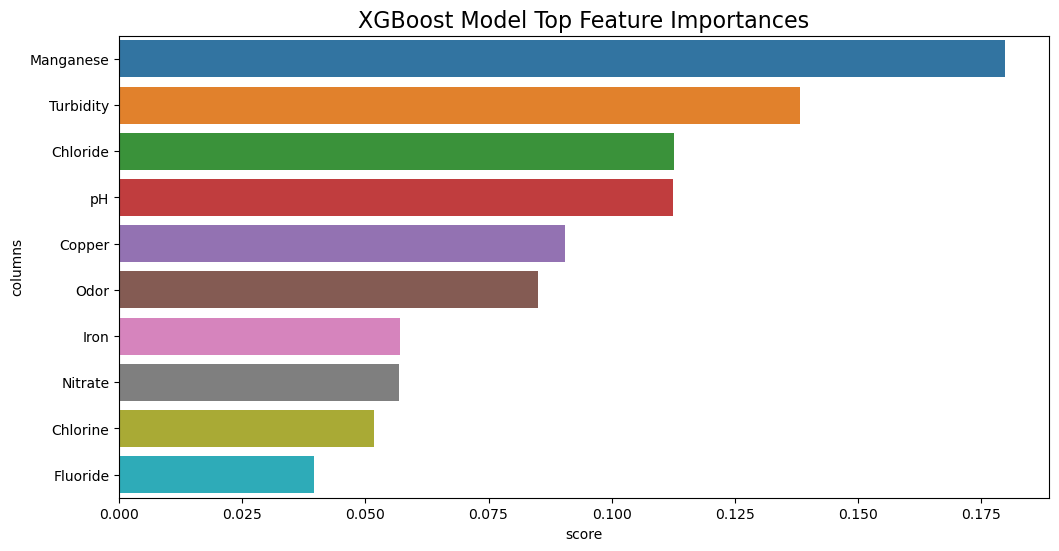

In [30]:
feature_imp_plot(X,xgb_model.feature_importances_,"XGBoost Model Top Feature Importances")

### XGBoost inference time

In [31]:
%time test_prediction=xgb_model.predict(X_test)

CPU times: user 1.08 s, sys: 3.02 ms, total: 1.08 s
Wall time: 283 ms


In [32]:
#f1_score(y_test,daal_xgb_model_prediction)

### Convert an XGBoost model to oneDAL



In [33]:
daal_xgb_model=d4p.get_gbt_model_from_xgboost(xgb_model.get_booster())

### oneDAL XGBoost inference time

In [34]:
%time daal_xgb_model_prediction=d4p.gbt_classification_prediction(nClasses=2).compute(X_test,daal_xgb_model).prediction

CPU times: user 1.33 s, sys: 3.98 ms, total: 1.33 s
Wall time: 687 ms


### Confustion matrix for train and validation data

In [35]:
val_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_test,
                                                             daal_xgb_model_prediction)
                                            ,display_labels=['Safe to drink', 'Not safe to drink'])

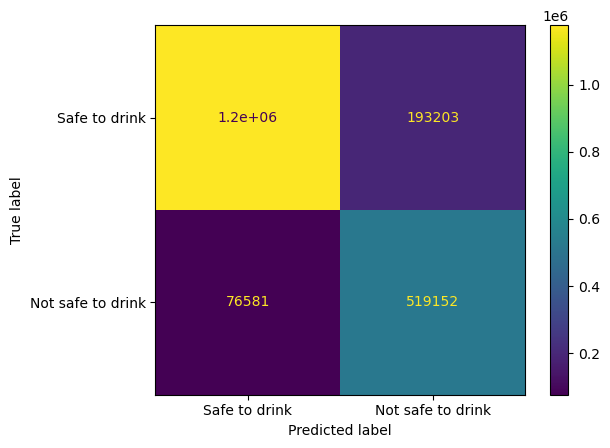

In [36]:
val_confusion_matrix.plot();

In [37]:
print(classification_report(y_test,daal_xgb_model_prediction,target_names=['Safe to drink', 'Not safe to drink']))

                   precision    recall  f1-score   support

    Safe to drink       0.94      0.86      0.90   1370025
Not safe to drink       0.73      0.87      0.79    595733

         accuracy                           0.86   1965758
        macro avg       0.83      0.87      0.85   1965758
     weighted avg       0.88      0.86      0.87   1965758



In [38]:
%time daal_xgb_model__train_prediction=d4p.gbt_classification_prediction(nClasses=2).compute(X_train,daal_xgb_model).prediction
train_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_train,
                                                               daal_xgb_model__train_prediction),
                                              display_labels=['Safe to drink', 'Not safe to drink'])

CPU times: user 2.73 s, sys: 4.96 ms, total: 2.74 s
Wall time: 1.38 s


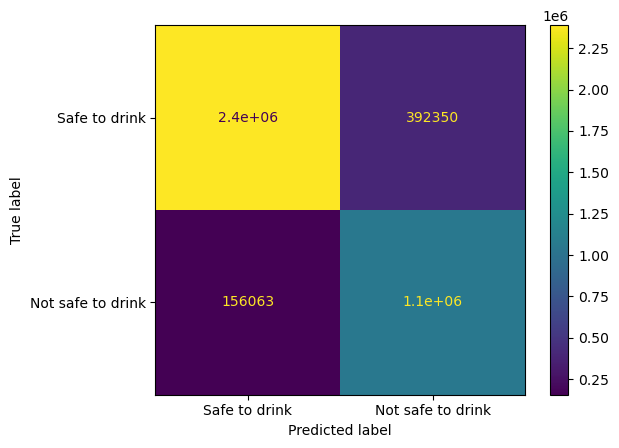

In [39]:
train_confusion_matrix.plot();

In [40]:
print(classification_report(y_train,daal_xgb_model__train_prediction,target_names=['Safe to drink', 'Not safe to drink']))

                   precision    recall  f1-score   support

    Safe to drink       0.94      0.86      0.90   2781565
Not safe to drink       0.73      0.87      0.79   1209519

         accuracy                           0.86   3991084
        macro avg       0.83      0.86      0.85   3991084
     weighted avg       0.88      0.86      0.87   3991084



### Let's use lightgbm model

In [41]:
lgbm_model=LGBMClassifier(verbose=-1)

In [42]:

lgbm_model.fit(X_train,y_train,eval_set=[(X_test,y_test)],
                     early_stopping_rounds=30,eval_metric='f1',
                     )

[1]	valid_0's binary_logloss: 0.558271
[2]	valid_0's binary_logloss: 0.514431
[3]	valid_0's binary_logloss: 0.478759
[4]	valid_0's binary_logloss: 0.44929
[5]	valid_0's binary_logloss: 0.424679
[6]	valid_0's binary_logloss: 0.403981
[7]	valid_0's binary_logloss: 0.386454
[8]	valid_0's binary_logloss: 0.37153
[9]	valid_0's binary_logloss: 0.358782
[10]	valid_0's binary_logloss: 0.347857
[11]	valid_0's binary_logloss: 0.338472
[12]	valid_0's binary_logloss: 0.330393
[13]	valid_0's binary_logloss: 0.323425
[14]	valid_0's binary_logloss: 0.31741
[15]	valid_0's binary_logloss: 0.312212
[16]	valid_0's binary_logloss: 0.307711
[17]	valid_0's binary_logloss: 0.303802
[18]	valid_0's binary_logloss: 0.300424
[19]	valid_0's binary_logloss: 0.297473
[20]	valid_0's binary_logloss: 0.294937
[21]	valid_0's binary_logloss: 0.292735
[22]	valid_0's binary_logloss: 0.290804
[23]	valid_0's binary_logloss: 0.289155
[24]	valid_0's binary_logloss: 0.287708
[25]	valid_0's binary_logloss: 0.286428
[26]	valid_0

LGBMClassifier(verbose=-1)

### Feature importances plot

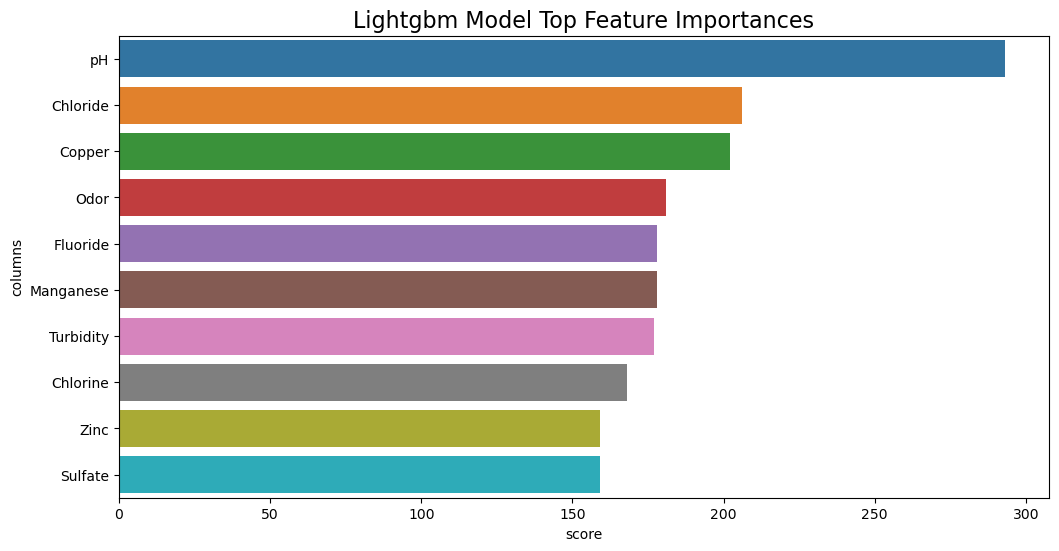

In [43]:
feature_imp_plot(X,lgbm_model.feature_importances_,"Lightgbm Model Top Feature Importances")

### Lightgbm inference time


In [44]:
%time lgbm_test_prediction=lgbm_model.predict(X_test)


CPU times: user 13.8 s, sys: 72.6 ms, total: 13.9 s
Wall time: 3.79 s



### Convert an Lightgbm model to oneDAL

In [45]:
daal_lgbm_model=d4p.get_gbt_model_from_lightgbm(lgbm_model.booster_)

### oneDAL lightgbm inference time

In [46]:
%time daal_lgbm_model_prediction=d4p.gbt_classification_prediction(nClasses=2).compute(X_test,daal_lgbm_model).prediction

CPU times: user 15.6 s, sys: 7.37 ms, total: 15.7 s
Wall time: 7.85 s


### Confustion matrix for train and validation data

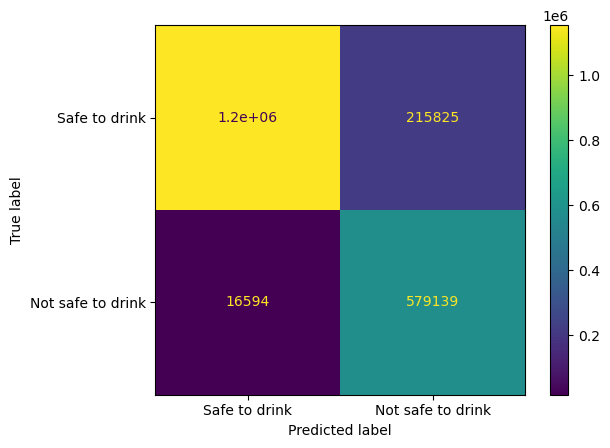

In [47]:
lgbm_val_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_test,
                                                             daal_lgbm_model_prediction)
                                            ,display_labels=['Safe to drink', 'Not safe to drink'])

lgbm_val_confusion_matrix.plot();

In [48]:
print(classification_report(y_test,daal_lgbm_model_prediction,target_names=['Safe to drink', 'Not safe to drink']))

                   precision    recall  f1-score   support

    Safe to drink       0.99      0.84      0.91   1370025
Not safe to drink       0.73      0.97      0.83    595733

         accuracy                           0.88   1965758
        macro avg       0.86      0.91      0.87   1965758
     weighted avg       0.91      0.88      0.89   1965758



CPU times: user 32 s, sys: 6.55 ms, total: 32 s
Wall time: 16 s


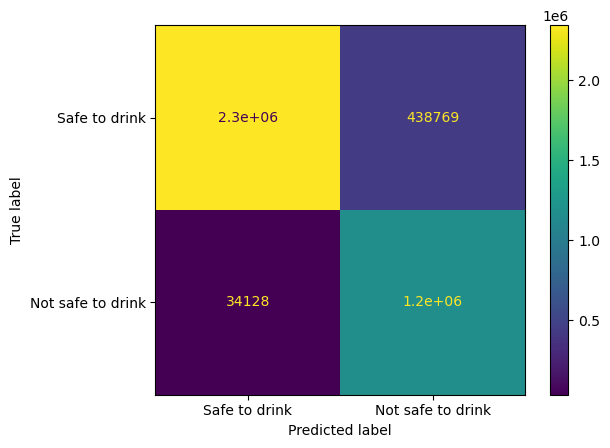

In [49]:
%time daal_lgbm_model__train_prediction=d4p.gbt_classification_prediction(nClasses=2).compute(X_train,daal_lgbm_model).prediction

lgbm_train_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_train,
                                                               daal_lgbm_model__train_prediction),
                                              display_labels=['Safe to drink', 'Not safe to drink'])


lgbm_train_confusion_matrix.plot();


In [50]:
print(classification_report(y_train,daal_lgbm_model__train_prediction,target_names=['Safe to drink', 'Not safe to drink']))

                   precision    recall  f1-score   support

    Safe to drink       0.99      0.84      0.91   2781565
Not safe to drink       0.73      0.97      0.83   1209519

         accuracy                           0.88   3991084
        macro avg       0.86      0.91      0.87   3991084
     weighted avg       0.91      0.88      0.89   3991084



### Let's create catboost model

In [51]:
cat_clf=CatBoostClassifier(random_seed=45,eval_metric='F1',verbose=False,)

In [52]:
cat_clf.fit(X_train,y_train,eval_set=(X_test,y_test),early_stopping_rounds=100)

### Feature importance plot.

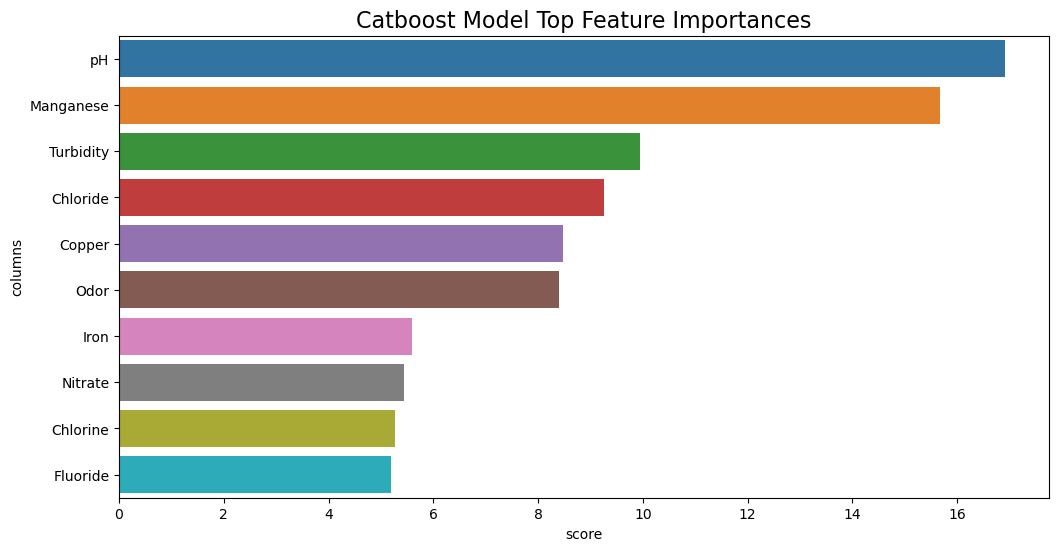

In [53]:
feature_imp_plot(X,cat_clf.get_feature_importance(),"Catboost Model Top Feature Importances")

### Catboost inference time

In [54]:
%time cat_test_prediction=cat_clf.predict(X_test)


CPU times: user 2.93 s, sys: 23 ms, total: 2.95 s
Wall time: 2.95 s


In [55]:
#f1_score(y_test,daal_catb_model_prediction)

### Convert an catboost model to oneDAL

In [56]:
daal_catb_model=d4p.get_gbt_model_from_catboost(cat_clf)


### oneDAL catboost inference time

In [57]:
%time daal_catb_model_prediction=d4p.gbt_classification_prediction(nClasses=2).compute(X_test,daal_catb_model).prediction


CPU times: user 38.8 s, sys: 7.29 ms, total: 38.8 s
Wall time: 19.4 s


### Confustion matrix for train and validation data

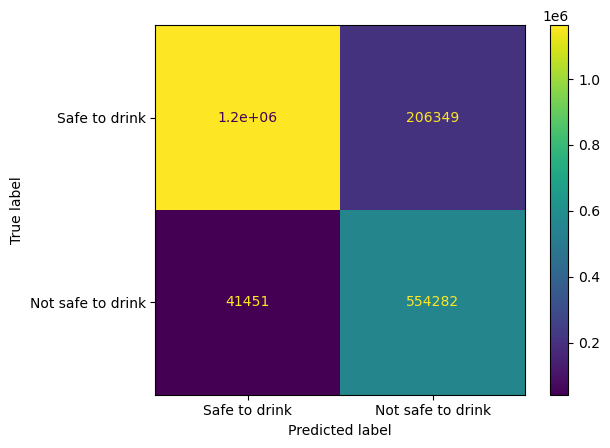

In [58]:
catb_val_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_test,
                                                             daal_catb_model_prediction)
                                            ,display_labels=['Safe to drink', 'Not safe to drink'])

catb_val_confusion_matrix.plot();

In [59]:
print(classification_report(y_test,daal_catb_model_prediction,target_names=['Safe to drink', 'Not safe to drink']))

                   precision    recall  f1-score   support

    Safe to drink       0.97      0.85      0.90   1370025
Not safe to drink       0.73      0.93      0.82    595733

         accuracy                           0.87   1965758
        macro avg       0.85      0.89      0.86   1965758
     weighted avg       0.89      0.87      0.88   1965758



CPU times: user 2.71 s, sys: 1.02 ms, total: 2.71 s
Wall time: 1.36 s


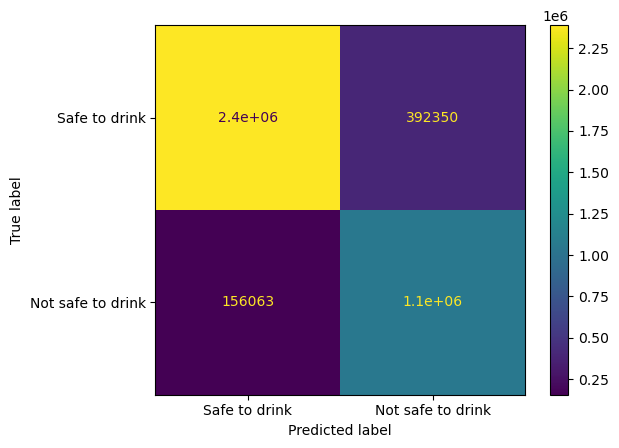

In [60]:
%time daal_cat_model__train_prediction=d4p.gbt_classification_prediction(nClasses=2).compute(X_train,daal_xgb_model).prediction
catb_train_confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_train,
                                                               daal_cat_model__train_prediction),
                                              display_labels=['Safe to drink', 'Not safe to drink'])


catb_train_confusion_matrix.plot();


In [61]:
print(classification_report(y_train,daal_cat_model__train_prediction,target_names=['Safe to drink', 'Not safe to drink']))

                   precision    recall  f1-score   support

    Safe to drink       0.94      0.86      0.90   2781565
Not safe to drink       0.73      0.87      0.79   1209519

         accuracy                           0.86   3991084
        macro avg       0.83      0.86      0.85   3991084
     weighted avg       0.88      0.86      0.87   3991084



### Let's compare the models F1 score.

In [62]:
resul_df=pd.DataFrame(columns=['Model_Name','Type_of_Data','F1_score'])
for name,model in zip(['XGBoost','Lightgbm','Catboost'],[daal_xgb_model,daal_lgbm_model,daal_catb_model]):
        for datatype in ['train','validation']:
            if datatype =='train':
                score=f1_score(y_train,d4p.gbt_classification_prediction(nClasses=2).compute(X_train,model).prediction)
                resul_df.loc[len(resul_df)]=[name,datatype,score]
            elif datatype =='validation':
                score=f1_score(y_test,d4p.gbt_classification_prediction(nClasses=2).compute(X_test,model).prediction)
                resul_df.loc[len(resul_df)]=[name,datatype,score]
            
                
            
            

In [63]:
resul_df

,Model_Name,Type_of_Data,F1_score
0,XGBoost,train,0.793467
1,XGBoost,validation,0.793757
2,Lightgbm,train,0.832525
3,Lightgbm,validation,0.832876
4,Catboost,train,0.819155
5,Catboost,validation,0.817306


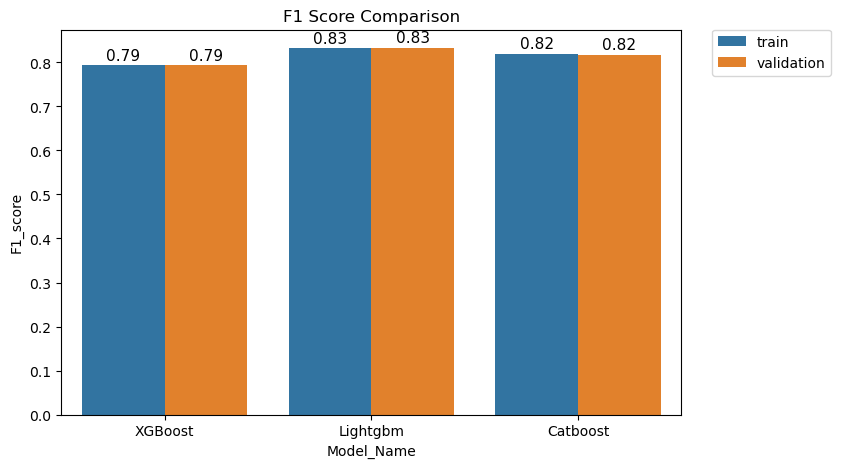

In [64]:
_=plt.figure(figsize=(8,5))
sns.barplot(data=resul_df,x='Model_Name',y='F1_score',hue='Type_of_Data');
_=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax = plt.gca()
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 7),
                textcoords='offset points')
_=plt.title("F1 Score Comparison")

#### The above plot explains that the lightgbm model performs better on both train and test data.

### Let's understand the lightgbm model with shapash

In [65]:
!pip install shapash -q

In [66]:
from shapash import SmartExplainer
from shapash.explainer.smart_predictor import SmartPredictor
from shapash.utils.load_smartpredictor import load_smartpredictor

### Let's declare and compile SmartExplainer for lightgbm model

In [67]:
feature_dict = {col:f"about_{col}" for col in X_train.columns}
label_dict = {0: "Not safe to drink", 1: "Safe to drink"}

In [68]:
lgbm_xpl=SmartExplainer(
    model=lgbm_model,label_dict = {0: "Not safe to drink", 1: "Safe to drink"}
    )


In [69]:


lgbm_xpl.compile(x=X_test,
 y_pred=pd.DataFrame(lgbm_test_prediction,columns=['Target'],index=y_test.index),
 y_target=y_test, # Optional: allows to display True Values vs Predicted Values
 )

### Lightgbm Model Features importances SHAP

In [78]:
lgbm_xpl.plot.features_importance()

### Subset importances

### Let's take 10 samples from each class and see the feature importance.

In [79]:
y_test[y_test==1].index

Int64Index([4642920, 1982184,  741199, 5882817, 5951701, 3111599, 2723276,
            1166197, 4707813, 3099090,
            ...
            3906414, 5109363, 3150618, 5906744,  344108, 3918971, 5955590,
            5841087, 4646348, 1516916],
           dtype='int64', length=595733)

In [88]:
y_test[y_test==0]%%!.index

Int64Index([2843577, 1610572, 1429181, 2405952,  521610,  454228, 2807684,
            4064876, 2480755, 2239755,
            ...
            5610876, 1224392, 4813231, 1843943, 1048427,   23691, 4128941,
            2252212, 3743848, 2857888],
           dtype='int64', length=1370025)

In [81]:
subset = [4642920, 1982184,  741199, 5882817, 5951701, 3111599, 2723276,1166197, 
     4707813, 3099090,2843577, 1610572, 1429181, 2405952,  521610,  454228,
     2807684, 4064876, 2480755, 2239755]
lgbm_xpl.plot.features_importance(selection=subset)

### Local explantion for class 1(safe to drink)

In [93]:
lgbm_xpl.plot.local_plot(index=4642920,label=1)

### Local explantion for class 0(not safe to drink)

In [92]:
lgbm_xpl.plot.local_plot(index=23691,label=0)

### Let's declare and compile SmartExplainer for catboost model

In [96]:
catboost_xpl=SmartExplainer(
    model=cat_clf,
    label_dict = {0: "Not safe to drink", 1: "Safe to drink"}
    )


In [97]:

catboost_xpl.compile(x=X_test,
 y_pred=pd.DataFrame(cat_test_prediction,columns=['Target'],index=y_test.index),
 y_target=y_test, # Optional: allows to display True Values vs Predicted Values
 )

### Catboost Model Features importances SHAP

In [98]:
catboost_xpl.plot.features_importance()

### Subset importances

In [99]:
catboost_xpl.plot.features_importance(selection=subset)

### Local explantion for class 1(safe to drink)

In [100]:
catboost_xpl.plot.local_plot(index=4642920,label=1)

### Local explantion for class 1(safe to drink)

In [101]:
catboost_xpl.plot.local_plot(index=23691,label=0)

### Catboost model used for the streamlit model demo.

### Convert the catboost SmartExplainer to SmartPredictor

In [102]:
catboost_predictor = catboost_xpl.to_smartpredictor()

### Save the catboost SmartPredictor in Pickle File

In [103]:
catboost_predictor.save("shapash_catboost_smart_predictor.pkl")

### Let's save oneDAL catboost model

In [104]:
import pickle


In [108]:
pickle.dump(daal_catb_model, open('Catboost_oneDAL_model.pkl', 'wb'))
 